<a href="https://colab.research.google.com/github/juanosoriodata/atari/blob/master/Atari.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Hecho por *Juan Felipe Osorio Ramírez* en el curso de Minería de Datos en la Universidad Nacional de Colombia, Sede Bogotá.

El contenido (imágenes y teoría) se toma de las siguientes referencias y tiene con último fin la **academia**:
1. Saito, S., Wenzhuo, Y., & Shanmugamani, R. (2018). Python Reinforcement Learning Projects: Eight hands-on projects exploring reinforcement learning algorithms using TensorFlow. Packt Publishing Ltd.

2. Evans, L. C. (1983). An introduction to mathematical optimal control theory version 0.2. Lecture notes available at http://math.berkeley.edu/~evans/control.course.pdf .

3. Sutton, R. S., & Barto, A. G. (1998). Introduction to reinforcement learning (Vol. 135). Cambridge: MIT press.

4. Balakrishnan, K. (2020). TensorFlow Reinforcement Learning Quick Start Guide. Packt Publishing Ltd. 

***
# ATARI
***

![alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/3/3b/Atari_logo.svg/1280px-Atari_logo.svg.png)

Este cuaderno reproduce un proyecto de Aprendizaje Reforzado cuyo alcance es:
- Implementar un emulador del juego Atari usando `gym`.
- Explorar el preprocesamiento de datos en tareas de este tipo de aprendizaje, en este caso para el juego Atari.
- Explorar el algoritmo Q-learning.
- Implementar DQN usando TensorFlow y visualizar el entrenamiento.




## Intuición y Matemáticas detrás de escenas

### ¿Qué es el Aprendizaje Reforzado?

En este tipo de machine learning, se tiene un **agente** que se refiere al algoritmo/modelo que aprende una tarea específica.

El agente aprende principalmente al recibir una **señal de recompensa**, que es un escalar que indica que tan bien el agente está realizando la tarea.

Suponga que tenemos un agente cuya tarea es controlar el movimiento de caminar de un robot. El agente recibirá una recompensa positiva si logra hacer caminar el robot al destino fijado y recompensa negativa si se cae o no camina en dirección del destino.

Además, estas señales de recompensa se retornan como consecuencia de una serie de **acciones** que el agente realiza; esto a diferencia de como se retribuye la señal en un modelo de aprendizaje supervisado, en el cual se hace inmediatamente se entrena el modelo. Las acciones son simplemente esas opciones disponibles que tiene el agente para hacer en el **ambiente**. El ambiente se refiere al mundo en el que el agente vive y se encarga principalmente de retornar las señales de recompensa al agente. Las acciones del agente normalmente están condicionadas a lo que el agente percibe del ambiente. Lo que el agente percibe se concibe como la **observación** o el **estado** del ambiente. 

Nota: Lo que distingue el aprendizaje reforzado de otros paradigmas es que las acciones que realiza el agente pueden alterar el ambiente y sus respuestas subsecuentes.

#### Ejemplo: Space Invaders de Atari

En este caso el agente tiene como tarea jugar **Breakout**, el juego de Arcade Atari 2600. El ambiente es el juego como tal y la lógica que este tiene en sus especificaciones. Durante el juego, el agente consulta al ambiente para hacer una observación (que es equivalente a tener un estado). Aquí la observación es un array de tamaño $(210,160,3)$, que coincide  con la pantalla del juego que muestra la barra del agente, la pelota, los bloques a romper y el puntaje. Basado en esta observación, el agente realiza algunas acciones, que pueden incluir el moverse a la izquierda, derecha o quedarse quieto. El ambiente recibe la acción del agente como *input* y hace los respectivos *updates* al estado.

Por ejemplo, si la pelota toca un bloque, se remueve del juego. Si el agente decide moverse a la izquierda, el juego hará el update de cambiar las coordenadas de acuerdo a esto. Este proceso se repite hasta que se alcanza **estado terminal**, un estado que representa el final de una sucesión. En Breakout, el estado terminal se alcanza cuando la nave del agente es destruida, y el juego subsecuentemente retorna el puntaje que lleva, que se calcula con base en el número de naves enemigas que se destruyeron.

Nota: Algunos ambientes no tienen estados terminales, como el mercado de acciones. Estos siguen andando mientras existan.

#### Resumen de términos  

Término | Descripción | Ejemplos
--- | --- | ---
Agente | Un algoritmo/modelo que aprende una tarea específica. | Carros Self-Driving, Robots que caminan, **jugador de video juegos**. 
Ambiente | El mundo en el que el agente actúa. Es responsable de controlar los que el agente percibe y provee la retroalimentación sobre que tan bien el agente realiza la tarea. | El camino sobre el que anda el carro, **un video juego**, el mercado de las acciones.
Acción | La decisión que toma el agente en un ambiente, usualmente depende de lo que el agente percibe | Dirigir un carro, comprar o vender una acción, **disparar un laser de la nave que el agente controla**.
Señal de recompensa| Un escalar que indica que tan bien el agente está realizando una tarea.| **El puntaje de Space Invaders**, ROI de una compra de acción, distancia recorrida por un robot que intenta caminar.
Observación/Estado| Una descripción de el ambiente tal como la percibe el agente | Video desde una cámara, **la pantalla del juego**, estadísticas del mercado de acciones.
Estado terminal|Un estado en el que el agente no puede realizar más acciones.| Llegar al final de un laberinto, **la nave del agente en Space Invaders es destruida**.

Formalmente, miremos que sucede en el tiempo $t$ con un agente $P$ y un ambiente $E$:
1. $P$ consulta una observación $s_t$ de $E$. 
2. $P$ decide tomar una acción $a_t$ basada en la observación $s_t$.  
3. $E$ recibe $a_t$ y retorna una recompensa $r_t$ basado en la acción.
4. $P$ recibe $r_t$.
5. $E$ actualiza $s_t$ a $s_{t+1}$  basado en $a_t$  y otros factores.

Ahora, ¿De qué manera el ambiente calcula $r_t$ y $s_{t+1}$?

Para esto el ambiente usualmente tiene su propio algoritmo que calcula estos valores basado en numerosos *inputs/factors*, incluyendo la acción que el agente realiza.
A continuación, vamos a discutir en mayor detalle el mayor protagonista de cada problema de aprendizaje reforzado- el agente.

#### El Agente

El objetivo del agente de aprendizaje reforzado es aprender a desempeñar una tarea bien en un ambiente. Matemáticamente, esto significa que queremos maximizar la recompensa acumulada $R$, que se expresa así:

$R= r_0+\gamma^1r_1+\cdots+\gamma^tr_t$

En donde simplemente calculamos una suma ponderada de la recompensa recibida en cada tiempo $t$. $\gamma$ se llama un **factor de descuento**, y es un escalar que toma valores entre $0$ y $1$. La idea detrás de este factor es tal que a mayor tiempo transcurrido tiene la recompensa, menor valor tiene en R. Esto refleja también la perspectiva en las recompensas del mundo real, en la que preferimos recibir $100.000$ COP ahora *vs.* en un año. Ya que el valor de la recompensa puede ser mayor cuando estamos más cerca del presente. 

Debido a que la mecánica del ambiente no es completamente observable para el agente, este último debe ganar información al tomar acciones y observar como el ambiente reacciona a estas. Y de esta manera los humanos aprender a desempeñar sus tareas a lo largo de la vida.

Supongamos que estamos aprendiendo a jugar ajedrez. Si bien no tenemos todos los movimiento posibles guardados en memoria o no sabemos como jugará nuestro oponente, podemos mejorar nuestra competencia con el tiempo. En particular, podemos llegar a ser competentes en lo siguiente: 

- Aprender como reaccionar a un movimiento que hace nuestro oponente.
- Evaluar que tan buena es nuestra posición para ganar el juego.
- Predecir que hará nuestro oponente en la siguiente jugada y usar esto para decidir nuestro movimienot actual.
- Entender como jugarían los jugadores en general en una situación en la que nos encontramos en el momento.

De hecho, los agentes de aprendizaje reforzado pueden aprender a hacer cosas similares. En particular, un agente está compuesto de múltiples funciones y modelos para asistir su toma de decisión. Existen tres componentes que los agentes pueden tener: 
- Una **política**
- Una **función de valor**
- Un **modelo**

#### La *política* del *agente*

Una **política** es un algoritmo o un conjunto de reglas que describe como un agente toma sus decisiones. Un ejemplo de una, puede ser la estrategia que un inversionista usa para invertir en sus acciones, donde este compra una acción cuando los precios bajan y la vende cuando los precios suben.

Formalmente, una política es una función, denotada por $\pi$ que mapea un estado $s_t$ a una acción $a_t$:

$\pi(s_t)=a_t$

Lo cuál significa que el agente decide su acción tomando en cuenta su estado actual. Esta función puede representar muchas cosas, en la medida en que reciba un estado como input y una acción como output, sea una tabla, un grafo, o un clasificador de machine learning.

Siendo estrictos en la manera que definimos la política, esta resulta ser **determinística** y no en todas las aplicaciones es así. Es por esto que aparece una manera más general de definir la política y es de manera **estocástica** donde esta tiene como output una distribución de probabilidad sobre el conjunto de acciones posibles en un estado:

$\pi(a_t|s_t)=P(a_t|s_t)$

donde $\pi(a_t| s_t)$ es un vector de probabilidades normalizado sobre el conjunto de posibles acciones dado un estado. Aplicando al ejemplo de Atari este concepto de política, veamos la siguiente imagen.



In [ ]:
#@title
from google.colab import files
from IPython.display import Image
uploaded = files.upload()

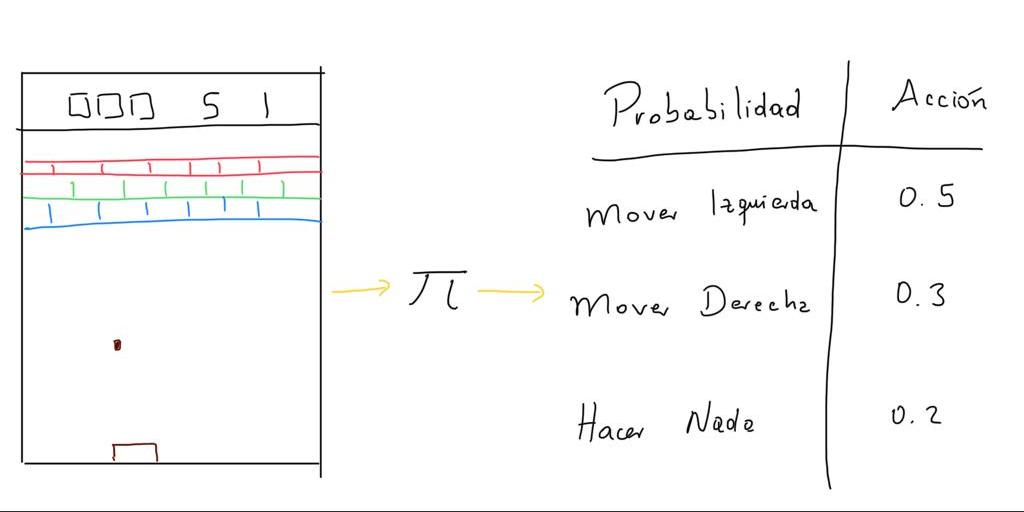

In [ ]:
#@title
Image('eb108444-97b9-4201-9aff-49ced33c3309.jpg', width = 600)

Imagen: Como la política mapea el estado del juego (la pantalla) a las acciones (probabilidades)


#### La *función de valor* del agente

El segundo componente que un agente puede tener es la **función de valor**. Como se mencionó en la introducción, es útil evaluar la posición, si es buena o mala, en un estado dado. En una partida de ajedrez, a un jugador le gustaría saber la verosimilitud de que va a ganar dado un estado del tablero. Un agente navegando un laberinto le gustaría saber que tan cerca está de llegar a su destino. La idea es que la función de valor quiere satisfacer los propósitos anteriores, ya que *predice el valor esperado de recompensa que un agente recibiría en un estado dado*. En otras palabras, mide que tan deseable es para el agente, su estado actual.

Formalmente, la función de valor toma un estado y una política como input y retorna un valor escalar representando la esperanza de la recompensa acumulada:

$v(s,\pi)= E[R|s,\pi]=E[r_0+\gamma^1r_1+\cdots+\gamma^tr_t|s,\pi]$

Ahora, ¿De qué manera esta función ayuda al agente a desempeñar una tarea bien, a parte de informar sobre que tan deseable es estar en un estado dado? Como veremos luego, las funciones de valor juegan un papel importante en predecir que tan bueno será el tomar una serie de acciones antes de que sean tomadas por el agente. Esto es similar a que los jugadores de ajedrez se imaginen qué tan bien una secuencia de acciones futuras funcionará para mejorar sus posibilidades de ganar. Para esto, el agente también necesita tener un entendimiento de como el ambiente opera. Y este entendimiento, resulta en el tercer componente de un agente que es, **el modelo**.


#### El *modelo* del agente

Anteriormente, se discutió como el agente no conoce completamente el ambiente. En otras palabras, el agente usualmente no tiene una idea de como se ve internamente el algoritmo completo del ambiente.

El agente necesita interactuar con el ambiente para ganar información y aprender como maximizar el valor esperado de la recompensar acumulada. Sin embargo, es posible para el agente tener una réplica interna, o un modelo, de el ambiente. El agente puede usar el modelo para predecir de qué manera el ambiente reaccionaría a alguna acción en un estado dado. Un modelo en el mercado de las acciones, por ejemplo, tiene la tarea de predecir como los precios serán en un futuro. Si el modelo es preciso, el agente puede entonces usar su función de valor para evaluar que tan deseable es el futuro. 

Formalmente, el modelo puede ser representado por una función $M$ que calcula la probabilidad del siguiente estado dado el estado actual y un acción: (MONTENEGRO?)

$M(a_t,s_t)=P(s_{t+1}|s_t,a_t)$

En otro escenarios, el modelo del ambiente puede ser usado para enumerar posibles estados futuros. Esto es común en juegos basados por turno, tales como el ajedrez o triki, donde las reglas y alcance de las posibles acciones están claramente definidas. Normalmente se hacen árboles de para ilustrar estas posibles sucesiones de acciones y estados de juegos basados en turno:


In [ ]:
#@title
uploaded = files.upload()


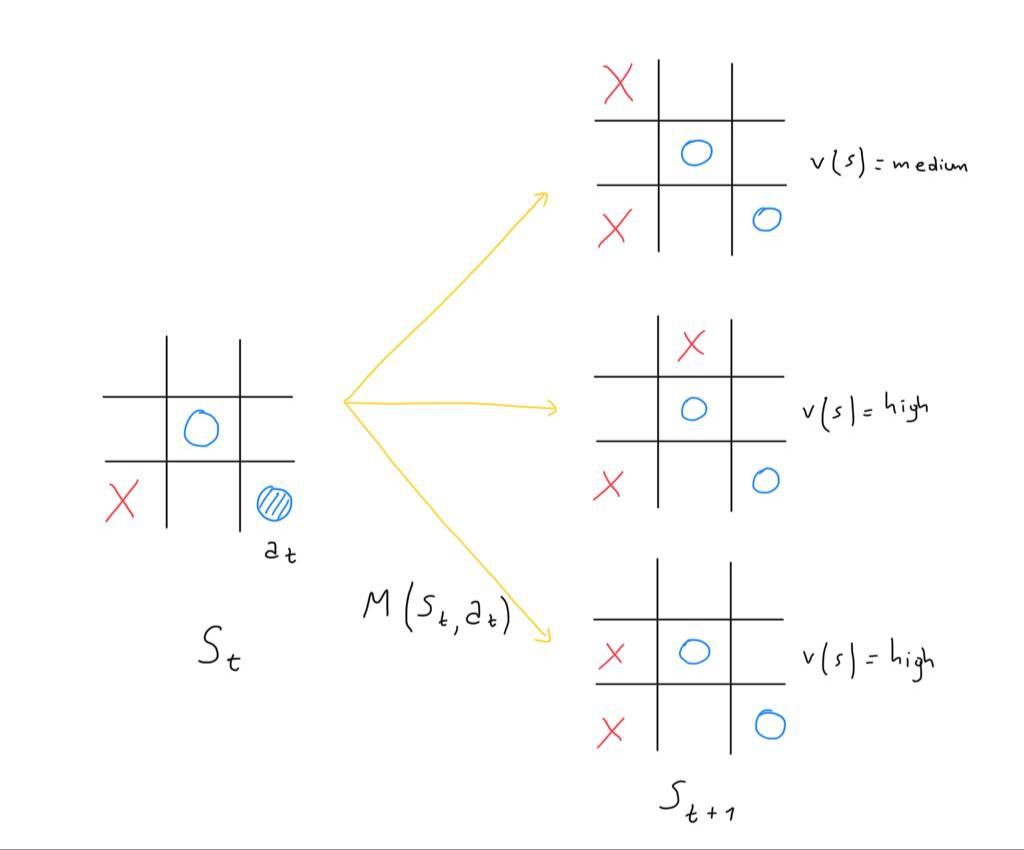

In [ ]:
#@title
Image('4466b8eb-0b71-414e-837f-49b0109e738f.jpg', width = 600)

Imagen: Un modelo usando su valor de función para evaluar sus posibles movimientos.

En el ejemplo anterior del juego triki, $M(s_t,a_t)$ denota los posibles estados que al tomar una acción $a_t$ (representada en la imagen como un círculo azul con rayas dentro) podría tomar en un estado dado $s_t$. Más aún, podemos calcular el valor de cada estado usando el valor de la *función de valor*. Los estados intermedios o de abajo en la imagen llevarían a obtener un valor alto ya que el agente estaría a un paso de ganar, caso contrario al caso de arriba ya que aquí se debe preocupar de que el oponente gane.


#### Resumen de términos

Término | Descripción | Output
--- | --- | ---
Política | Algoritmo/función que retorna decisiones que el agente toma. | Un escalar único (decisión) (política determinística) o un vector de probabilidades sobre posibles acciones (política estocástica)
Función de Valor |  Función que describe que tan bueno o malo es un estado dado. | Un valor escalar que representa el valor esperado de la recompensa acumulada.
Modelo | Una representación del ambiente que tiene el agente, que predice como reaccionará el ambiente a las acciones que el agente realiza.| La probabilidad del próximo estado dados una acción y el estado actual, o una enumeración de posibles estados dadas las reglas del ambiente.

Finalmente, usaremos estos conceptos para aprender uno de los marcos conceptuales fundamentales en aprendizaje reforzado: los **Procesos de Decisión de Markov**.


#### Procesos de Decisión de Markov (PDM)

Un **proceso de decisión de Markov** es un marco usado para representar el **ambiente** en un problema de aprendizaje reforzado. Este se puede representar gráficamente mediante un grafo con arcos dirigidos. Cada nodo representa un posible estado en el ambiente, y cada arco apuntando a un estado representa la acción que se puede tomar en el estado actual. 

>*Formalizaremos el problema del aprendizaje reforzado usando ideas de la Teoría de Sistemas Dinámicos, específicamente, el **control optimal de un proceso de decisión de Markov parcialmente-conocido**.*




Consideremos el siguiente ejemplo:

In [ ]:
#@title
uploaded = files.upload()


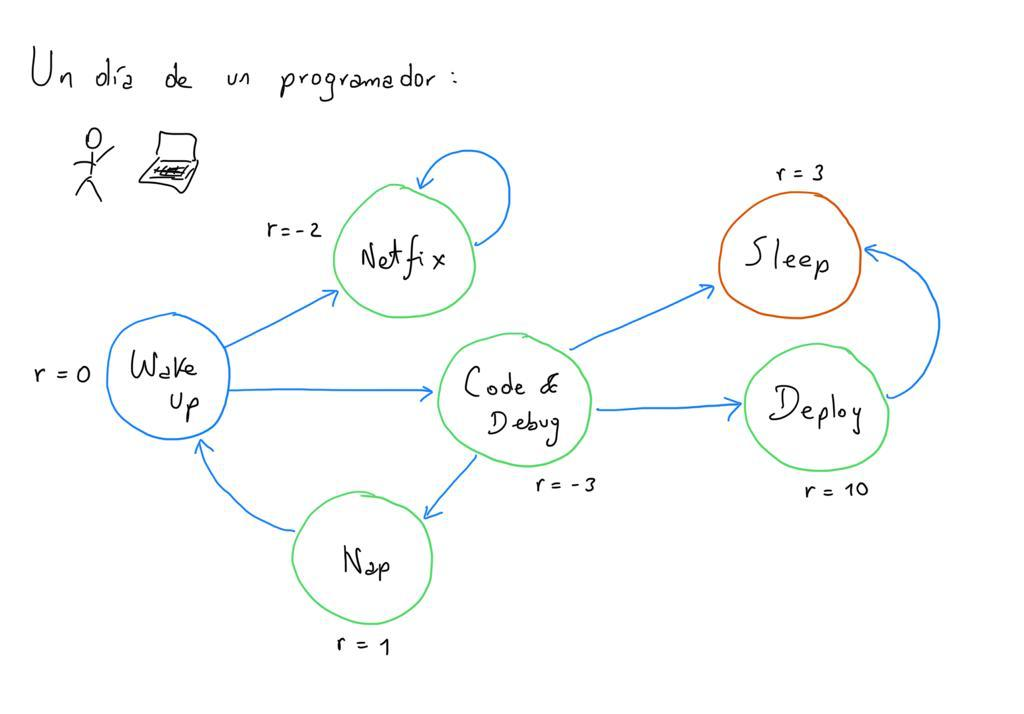

In [ ]:
#@title
Image('ff232de9-03c2-4ca7-8160-6e9320b6a0c6.jpg', width = 600)

Imagen: Un Proceso de Decisión de Markov.

El anterior PDM representa una jornada típica de un programador en un día. Cada círuclo representa un estado particular en el cual el programador puede estar, y en particular el estado azul (Wake up) es estado inicial (o el estado en $t=0$ que está el agente), y el estado naranja (Publish Code) denota el estado terminal. Cada estado tiene una recompensa que está asociada, y entre más alta sea, más deseable será.

Además una representación del grafo del ejemplo es su **matriz de adyacencia**:


State/Action | Wake Up | Netflix | Code and Debug | Nap | Deploy | Sleep
--- | --- | --- | --- | --- | --- | ---
Wake Up | N/A | -2 | -3 | 0 | N/A | N/A
Netflix | N/A | -2 | N/A | N/A | N/A | N/A
Code and Debug | N/A | N/A | N/A | 1 | 10 | 3
Nap | 0 | N/A | N/A | N/A | N/A | N/A
Deploy | N/A | N/A | N/A | N/A | N/A | 3
Sleep | N/A | N/A | N/A | N/A | N/A | N/A



La columna de la izquierda representa los posibles estados y la primera fila representan las posibles acciones. N/A siginifa que la acción no se puede realizar estan en el estado dado. Este sistema básicamente representa las decisiones que un programador puede realizar en un día.

Cuando el programador se levanta (*Wake up*), este puede decidir ir a trabajar (*Code and debug the code*) o ir a ver películas (*Netflix*). Nótese que la recompensa por ver Netflix es más alta que ir a trabajar. Para el programador en cuestión, ver Netflix resulta ser una actividad mejor recompensada, mientras que hacer código y debugging de este (que se espera no sea la misma idea del lector). Sin embargo, ambas acciones nos llevan a obtener recompensas negativas, pero recordemos que nuestro objetivo es maximizar la recompensa acumulada. Si el programador decide ver Netflix, se quedaría atrapado en un bucle infinito, que a la final termina debilitando la recompensa acumulada. Por otro lado, más estados con mejor recompensa estarán disponibles para el programador si se decide por trabajar.  

Examinemos las posibles trayectorias, que son sucesiones de acciones que el programador puede tomar:
- Wake Up | Netflix | Netflix | ...
- Wake Up | Code and Debug | Nap | Wake Up | Code and Debug | Nap | ...
- Wake Up | Code and Debug | Sleep
- Wake Up | Code and Debug | Deploy | Sleep

La primera y segunda trayectoria representan bucles infinitos. Calculemos la recompensa acumulada para cada una, donde hacemos $\gamma = 0.9$:
- $R = 0+0.9\times(-2)+0.9^2\times(-2)+0.9^3\times(-2)\cdots<0$
- $R = 0+0.9\times(-3)+0.9^2\times(1)+0.9^3\times(0)+0.9^4\times(-3)+0.9^5\times(1)\cdots<0 $
- $R = 0+0.9\times(-3)+0.9^2\times(3)=-0.27$
- $R = 0+0.9\times(-3)+0.9^2\times(10)+0.9^3\times(3)=7.587$

Podemos ver que para la primera y segunda trayectoria, a pesar de no tener un estado terminal, nunca tendremos recompensas positivas. La cuarta trayectoria nos brinda la recompensa acumulada más alta.



Lo que hemos calculado entonces son las funciones de valor para cuatros políticas que un programador puede tomar en un día. Recordemos que la función de valor es la esperanza de la recompensa acumulada empezando por un estado dado y siguiente un política. 

Hemos observado cuatro posibles políticas y evaluado como cada una de ellas nos lleva a obtener una recompensa acumulada distinta, ejercicio conocido como **evaluación de política**.

Más aún, las ecuaciones que hemos usado para calcular las recompensas esperadas son conocidas como **Ecuaciones de esperanza de Bellman**. Las ecuaciones de Bellman forman un conjunto de ecuaciones usadas para evaluar y mejorar políticas y funciones de valor para finalmente ayudar a un agente a desempeñar de mejor manera una tarea. 

Para ver más sobre estas ecuaciones fundamentales en el estudio de aprendizaje reforzado ver la referencia [3], al inicio de este cuaderno.


#### ¿Qué sigue ahora?

Ahora que hemos pasado por términos y conceptos clave de aprendizaje reforzado, el lector se preguntará por cómo enseñar a un agente de aprendizaje reforzado a maximizar su recompensa, o en otras palabras, tomando el ejemplo del PDM del programador, que sepa que la cuarta trayectoria es la mejor. 

Para nuestro proyecto con ATARI trabajaremos en la solución a este interrogante usando **Aprendizaje Profundo**. Para lo cuál haremos una sección introduciendo el tema. 

### ¿Qué es el Aprendizaje Profundo?

Este tipo de aprendizaje se ha convertido muy popular en los campos de estadística, ciencias de la computación y el machine learning. Gracias al aumento de recursos de máquina y datos, los algoritmos en este campo han sobrepasado los resultados de sus pasados estados del arte.

## Infrastructura y Dependecias 

## Aprendizaje de Máquina en Acción

### Entendamos el archivo model.py

#### Importamos los paquetes requeridos


In [ ]:
import numpy as np
import sys
import os
import random
import tensorflow as tf

#### Escogemos una red pequeña (smaller) o grande (bigger)

Usaremos dos arquitecturas de red neuronal, una llamda `bigger` y la otra llamada `smaller`. Usaremos la red `bigger` por ahora; si se quiere usar la otra opción para comparar rendimientos:

In [ ]:
NET = 'bigger' # 'smaller'

#### Escogemos la función de pérdida (L2 o Huber)

Para la función de pérdida del algoritmo Q-learning, podremos usar entre la pérdida `L2` o la de `huber`. Ambas opciones serán usadas en el resto del proyecto. Por ahora nos quedamos con `huber`:

In [ ]:
LOSS = 'huber' # 'L2'

#### Definimos los pesos de inicialización de la red

Especificaremos un inicializador de pesos para los pesos de la red. `tf.variance_scaling_initializer(scale = 2)` será usado para esta inicialización. Para el lector interesado, la inicialización con `tf.contrib.layers.xavier_initializer()` también se puede usar y se deja como comentario:

In [ ]:
init = tf.variance_scaling_initializer(scale = 2) # tf.contrib.layers.xavier_initializer()

#### Definimos la clase QNetwork()

Definiremos la clase `QNetwork()` como se resume enseguida. Tendrá un constructor `__init__` y las funciones `_build_model()`, `predict()` y `update()`. 

In [ ]:
class QNetwork():
    def __init__(self, scope="QNet", VALID_ACTIONS=[0, 1, 2, 3]):
        self.scope = scope
        self.VALID_ACTIONS = VALID_ACTIONS
        with tf.variable_scope(scope):
            self._build_model()
            
    def _build_model(self):
        # input placeholders; input is 4 frames of shape 84x84 
        self.tf_X = tf.placeholder(shape=[None, 84, 84, 4], dtype=tf.uint8, name="X")
        # TD
        self.tf_y = tf.placeholder(shape=[None], dtype=tf.float32, name="y")
        # action
        self.tf_actions = tf.placeholder(shape=[None], dtype=tf.int32, name="actions")

        # normalize input
        X = tf.to_float(self.tf_X) / 255.0
        batch_size = tf.shape(self.tf_X)[0]

#-------------
        
        if (NET == 'bigger'):
 
           # bigger net

           # 3 conv layers
           conv1 = tf.contrib.layers.conv2d(X, 32, 8, 4, padding='VALID', activation_fn=tf.nn.relu, weights_initializer=winit)
           conv2 = tf.contrib.layers.conv2d(conv1, 64, 4, 2, padding='VALID', activation_fn=tf.nn.relu, weights_initializer=winit)
           conv3 = tf.contrib.layers.conv2d(conv2, 64, 3, 1, padding='VALID', activation_fn=tf.nn.relu, weights_initializer=winit)

           # fully connected layers
           flattened = tf.contrib.layers.flatten(conv3)
           fc1 = tf.contrib.layers.fully_connected(flattened, 512, activation_fn=tf.nn.relu, weights_initializer=winit)


        elif (NET == 'smaller'): 
 
           # smaller net
   
           # 2 conv layers
           conv1 = tf.contrib.layers.conv2d(X, 16, 8, 4, padding='VALID', activation_fn=tf.nn.relu, weights_initializer=winit)
           conv2 = tf.contrib.layers.conv2d(conv1, 32, 4, 2, padding='VALID', activation_fn=tf.nn.relu, weights_initializer=winit)

           # fully connected layers
           flattened = tf.contrib.layers.flatten(conv2)
           fc1 = tf.contrib.layers.fully_connected(flattened, 256, activation_fn=tf.nn.relu, weights_initializer=winit)  
#-------------         

       

        # Q(s,a)
        self.predictions = tf.contrib.layers.fully_connected(fc1, len(self.VALID_ACTIONS), activation_fn=None, weights_initializer=winit)


        action_one_hot = tf.one_hot(self.tf_actions, tf.shape(self.predictions)[1], 1.0, 0.0, name='action_one_hot')
        self.action_predictions = tf.reduce_sum(self.predictions * action_one_hot, reduction_indices=1, name='act_pred')
 
        if (LOSS == 'L2'):
           # L2 loss
           self.loss = tf.reduce_mean(tf.squared_difference(self.tf_y, self.action_predictions), name='loss')
        elif (LOSS == 'huber'):
           # Huber loss
           self.loss = tf.reduce_mean(huber_loss(self.tf_y-self.action_predictions), name='loss')
        

        # optimizer 
        #self.optimizer = tf.train.RMSPropOptimizer(learning_rate=0.00025, momentum=0.95, epsilon=0.01)
        self.optimizer = tf.train.AdamOptimizer(learning_rate=2e-5)
        self.train_op = self.optimizer.minimize(self.loss, global_step=tf.contrib.framework.get_global_step())
        
    def predict(self, sess, s):
        return sess.run(self.predictions, { self.tf_X: s})

    def update(self, sess, s, a, y):
        feed_dict = { self.tf_X: s, self.tf_y: y, self.tf_actions: a }
        _, loss = sess.run([self.train_op, self.loss], feed_dict)
        return loss

Analicemos en detalle durante las siguientes subsecciones que hay dentro de la clase `QNetwork()`

##### El constructor `__init__` 

```python
class QNetwork():
    def __init__(self, scope = 'QNet', VALID_ACTIONS = [0,1,2,3]):
        self.scope = scope
        self.VALID_ACTIONS = VALID_ACTIONS
        with tf.variable_scope(scope):
            self._build_model()      
```  

##### La función `_build_model()`

En la función `_build_model()`, primero definiremos los placeholders `tf_X`, `tf_Y` y `tf_actions`. Nótese que los frames de las imágenes son almacenados en un formato `uint8` en el replay del buffer para guardar memoria, y se normalizarán al convertirlos a `float` y luego dividiéndolos por $255.0$ para colocar el input `X` en el rango $(0,1)$:

```python    
    def _build_model(self):
        # input placeholders; input is 4 frames of shape 84x84
        self.tf_X = tf.placeholder(shape = [None,84,84,4], dtype = tf.float32, name = 'X')
        # TD
        self.tf_Y = tf.placeholder(shape = [None], dtype = tf.float32, name = 'y')
        # actions 
        self.tf_actions = tf.placeholder(shape = [None], dtype = tf.int32, name = 'actions')
        # normalize input 
        X = tf.to_float(self.tf_X)/255
        batch_size = tf.shape(self.tf_X)[0]
        
```         

Ahora definamos las **capas de convolución**: Como se mencionó, tenemos una opción para nuestra red `bigger` y otra `smaller`.

La red `bigger` tiene $3$ capas convolucionales, seguida de $1$ capa completamente conectada.

La red `smaller` tiene $2$ capas convolucionales, seguida de $1$ capa completamente conectada. 

Podemos definir las capas convolucionales en TensorFLow usando `tf.contrib.layers.conv2d()`, y capas completamente conectadas usando `tf.contrib.layers.fully_connected()`. Notemos que, luego de la última capa convolucional, tenemos que aplanar nuestro output antes de pasarlo a la capa completamente conectada, para lo cuál se usa `tf.contrib.layers.flatten()`. Usaremos el objeto `winit` como nuestro inicializador de pesos, que definimos anteriormente:   

```python
        if (NET == 'bigger'):
            # bigger net
            # 3 conv layers
            conv1 = tf.contrib.layers.conv2d(X, 32, 8, 4, padding = 'VALID', activation_fn = tf.nn.relu, weights_initializer = winit)
            conv2 = tf.contrib.layers.conv2d(conv1, 64, 4, 2, padding = 'VALID', activation_fn = tf.nn.relu, weights_initializer = winit)
            conv3 = tf.contrib.layers.conv2d(conv2, 64, 3, 1, padding = 'VALID', activation_fn = tf.nn.relu, weights_initializer = winit)
            #fully connected layers
            flattened = tf.contrib.layers.flatten(conv3)
            fc1 = tf.contrib.layers.fully_connected(flattened, 512, activation_fn = tf.nn.relu, weights_initializer = winit)
        
        elif (NET == 'smaller'):
            # smaller net
            # 2 conv layers
            conv1 = tf.contrib.layers.conv2d(X, 16, 8, 4, padding = 'VALID', activation_fn = tf.nn.relu, weights_initializer = winit)
            conv2 = tf.contrib.layers.conv2d(conv1, 32, 4, 2, padding = 'VALID', activation_fn = tf.nn.relu, weights_initializer = winit)
            # fully connected layers
            flattened = tf.contrib.layers.flatten(conv2)
            fc1 = tf.contrib.layers.fully_connected(flattened, 256, activation_fn = tf.nn.relu, weights_initializer = winit)
```

Continuamos por definir la **capa completamente conectada**: Para terminar en la función `_build_model()`, tenemos una capa completamente conectada cuyo tamaño coincide con el número de posible de acciones, que se especifica mediante `len(self.VALID_ACTIONS)`. El output de esta capa se almacena en `self.predictions`, y representa $Q(s,a)$, y que vimos en la teoría de este cuaderno. 

Las acciones que pasamos a esta función, i.e., `self.tf_actions` debe ser convertida al formato one-hot, para lo cuál usamos `tf.one_hot()`. Nótese que el formato `one_hot` es una manera de representar el número de acción como un array binario con cero en todas las acciones, expecto por una acción, la cuál se almacena con un valor de `1.0`. 

Luego se multiplican las predicciones con las acciones en formato one-hot usando `self.predictions * action_one_hot`, y el resultado se suma usando `tf.reduce_sum()`; esa cantidad finalmente se almacena en la variable `self.action_predictions`:

```python        
        # Q(s,a)
        self.predictions = tf.contrib.layers.fully_connected(fc1, len(self.VALID_ACTIONS), activation_fn = None, weights_initializer = winit)
        action_one_hot = tf.one_hot(self.tf_actions, tf.shape(self.predictions)[1], 1.0, 0.0, name = 'action_one_hot')
        self.action_predictions = tf.reduce_sum(self.predictions * action_one_hot, reduction_indices = 1, name = 'act_pred')
```        

Calculamos la **función de pérdida** para el entrenamiento de la red: Calculamos la función de pérdida para el entrenamiento de la red, que estará almacenada en `self.loss`, usando la pérdida L2 o la de Huber, que se determina usando la variable `LOSS`. 

Para la pérdida L2, usamos la función `tf.squared_difference()`, y para la de Huber usamos `huber_loss()` que pronto definiremos. La pérdida se promedia sobre muchas muestras, y para esto usaremos la función `tf.reduce_mean()`. 

Nótese que se calculará la pérdida entre el placeholder `tf_y` definido al comienzo y la variable `action_predictions` que obtuvimos en el último paso.


```python        
        if (LOSS == 'L2'):
            # L2 loss
            self.loss = tf.reduce_mean(tf.squared_difference(self.tf_y, self.action_predictions), name = 'loss')
        elif (LOSS == 'huber'):
            # Huber loss
            self.loss = tf.reduce_mean(huber_loss(self.tf_y-self.action_predictions), name = 'loss')
```            

Usando un **optimizador**: Usaremos el optimizador RMSprop o Adam, y lo almacenaremos en `self.optimizer`. Nuestro objetivo de aprendizaje estará en minimizar `self.loss`, y para esto usaremos `self.optimizer.minimize()`. Esta última cantidad está almacenada en `self.train_op`

```python        
        # optimizer
        # self.optimizer = tf.train.RMSPropOptimizer(learning_rate = 0.00025, momentum = 0.95, epsilon = 0.01)
        self.optimizer = tf.train.AdamOptimizer(learning_rate = 2e-5)
        self.train_op = self.optimizer.minimizer(self.loss, global_step = tf.contrib.framework.get_global_step())
```

##### La función `predict()`

En la función `predict()`, corremos la función `self.predictions` definida previamente usando `sess.run()` de TensorFlow, donde `sess` es el objeto de tipo `tf.Session()` que se para como parámetro a esta función.

Los estados se pasan como argumentos en esta función en la variable `s`, el cuál se pasará al placeholder, `tf_X`: 

```python
    def predict(self, sess, s):
        return sess.run(self.predictions, {self.tf_X: s})
```

##### La función `update()`

Finalmente, en la función `update()`, llamaremos los objetos `train_op` y `loss`, y alimentamos el diccionario `a` en los placeholders involucrados en estas operaciones, el cuál llamamos `feed_dict`. Los estados estan almacenados en `s`, las acciones en `a`, y los targets en `y`: 

```python    
    def update(self, sess, s, a, y):
        feed_dict = {self.tf_X : s, self.tf_y : y, self.tf_actions : a}
        _, loss = sess.run([self.train_op,self.loss], feed_dict)
        return loss
```

#### Definimos la función `huber_loss()`

La función de pérdida de Huber es una mezcla entre las pérdidas L1 Y L2. Cuando el input es menor que $1$, toma el valor de la pérdida L2, y toma la L1 en otro caso:

In [ ]:
# huber loss
def huber_loss(x):
    condition = tf.abs(x) < 1.0
    output1 = 0.5 * tf.square(x)
    output2 = tf.abs(x) - 0.5
    return tf.where(condition, output1, output2)

### Usando el archivo funcs.py

#### Importamos los paquetes

In [ ]:
import numpy as np
import sys
import tensorflow as tf

#### Definimos la clase `ImageProcess()`

Ahora convertimos las imágenes de tamaño 210x160x3 y de tipo RGB del emulador de Atari a una imagen de escala de grises 84x84. Para esto, crearemos la clase `ImageProcess()` y usamos funciones de utilidad de TensorFlow, tales como:
- `rgb_to_gray_scale()` para convertir la imagen de RGB a escala de grises 
- `crop_to_bounding_box()` para recortar la región de interes de una imagen
- `resize_images()` para redimensionar la imagen a 84x84
- `squeeze()` para remover una dimensión del input
Finalmente incluímos una función `process()` a la clase y que se encargará de las operaciones que invocarán la función `sess.run()` en `self.output()`.

Nótese que pasamos la variable `state` como un diccionario:

In [ ]:
# convert raw Atari RGB image of size 210x160x3 into 84x84 grayscale image
class ImageProcess():
    def __init__(self):
        with tf.variable_scope("state_processor"):
            self.input_state = tf.placeholder(shape = [210, 160, 3], dtype = tf.uint8)
            self.output = tf.image.rgb_to_grayscale(self.input_state)
            self.output = tf.image.crop_to_bounding_box(self.output, 34, 0, 160, 160)
            self.output = tf.image.resize_images(self.output, [84, 84], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
            self.output = tf.squeeze(self.output)
    def process(self, sess, state):
        return sess.run(self.output, { self.input_state: state })

#### Copiamos los parámetros de una red a otra

El siguiente paso consiste en escribir una función llamada `copy_model_parameters()`, la cuál tomará como argumentos:

- `sess`: objeto de tipo `tf.Session()`
- qnet1 : Red neuronal (en nuestro caso será Q-network)
- qnet2 : Red neuronal (en nuestro caso será la red target) 

La función copiará los valores de parámetros de `qnet1` a `qnet2`: 

In [ ]:
# copy params from qnet1 to qnet2
def copy_model_parameters(sess, qnet1, qnet2):
    q1_params = [t for t in tf.trainable_variables() if t.name.startswith(qnet1.scope)]
    q1_params = sorted(q1_params, key=lambda v: v.name)
    q2_params = [t for t in tf.trainable_variables() if t.name.startswith(qnet2.scope)]
    q2_params = sorted(q2_params, key=lambda v: v.name)
    update_ops = []
    for q1_v, q2_v in zip(q1_params, q2_params):
        op = q2_v.assign(q1_v)
        update_ops.append(op)
    sess.run(update_ops)

#### Definimos una función para usar la estrategia $\epsilon$-greedy para explorar o aprovechar

Ahora escribiremos una función llamada `epsilon_greedy_policy()`, la cuál explorará o aprovechará dependiendo de si un número real aleatorio calculado usando la función de numpy `np.random.rand()` es menor que `epsilon`, parámetro descrito anteriormente en la estrategia $\epsilon$-greedy.

Para la exploración, todas las acciones son equiprobables con probabilidad igual a $\frac{1}{\text{num_actions}}$, donde `num_actions` es el número posible de acciones (que para nuestro caso en el juego Breakout es $4$).

Y para aprovechar, usaremos la función `predict()` de la $Q$-Network para obtener los $Q$-valores e identificar que acciones tiene el valor de $Q$ más alto, todo esto mediante la función de numpy `np.argmax()`. La salida de esta función es la probabilidad de cada una de las acciones, que para el aprovechar, tendrá todos sus valores `0` excepto por la acción que tiene el valor de $Q$ más alto, para la cuál se le asignará un valor de `1.0`:

In [ ]:
# epsilon-greedy
def epsilon_greedy_policy(qnet, num_actions):
    def policy_fn(sess, observation, epsilon):
        if (np.random.rand() < epsilon):  
          # explore: equal probabiities for all actions
          A = np.ones(num_actions, dtype=float) / float(num_actions)
        else:
          # exploit 
          q_values = qnet.predict(sess, np.expand_dims(observation, 0))[0]
          max_Q_action = np.argmax(q_values)
          A = np.zeros(num_actions, dtype=float)
          A[max_Q_action] = 1.0 
        return A
    return policy_fn

#### La función `populate_replay_mem` para poblar la memoria de replay

In [ ]:
# populate replay memory
def populate_replay_mem(sess, env, state_processor, replay_memory_init_size, policy, epsilon_start, epsilon_end, epsilon_decay_steps, VALID_ACTIONS, Transition):
    state = env.reset()
    state = state_processor.process(sess, state)
    state = np.stack([state] * 4, axis=2)

    delta_epsilon = (epsilon_start - epsilon_end)/float(epsilon_decay_steps)

    replay_memory = []

    for i in range(replay_memory_init_size):
        epsilon = max(epsilon_start - float(i) * delta_epsilon, epsilon_end)
        action_probs = policy(sess, state, epsilon)
        action = np.random.choice(np.arange(len(action_probs)), p=action_probs)

        env.render()   
        next_state, reward, done, _ = env.step(VALID_ACTIONS[action])

        next_state = state_processor.process(sess, next_state)
        next_state = np.append(state[:,:,1:], np.expand_dims(next_state, 2), axis=2)
        replay_memory.append(Transition(state, action, reward, next_state, done))

        if done:
            state = env.reset()
            state = state_processor.process(sess, state)
            state = np.stack([state] * 4, axis=2)
        else:
            state = next_state
    return replay_memory

Veamos acontinuación cada parte de la función

Escribiremos una función `populate_replay_mem` para poblar el replay buffer con un número de muestras `replay_memory_init_size`.

Primero, reseteamos nuestro ambiente usando `env.reset()`. Luego procesamos el estado obtenido del reset. Necesitamos 4 frames para cada estado, ya que el agente por otra parte no tiene manera de determinar el movimiento de la paleta o su velocidad. 

Para el primer frame, apilamos cuatro copias. También calculamos `delta_epsilon`, que es la cantidad que decrece epsilon por time step. 

La memoria de replay se inicializa como una lista vacía:

```python
# populate replay memory
def populate_replay_mem(sess, env, state_processor, replay_memory_init_size, policy, epsilon_start, epsilon_end, epsilon_decay_steps, VALID_ACTIONS, Transition):
    state = env.reset()
    state = state_processor.process(sess, state)
    state = np.stack([state] * 4, axis=2)

    delta_epsilon = (epsilon_start - epsilon_end)/float(epsilon_decay_steps)

    replay_memory = []
```

Ahora calculamos las **probabilidades de acciones**: Lo que significa es que haremos, un loop por `replay_memory_init_size` cuatro veces, disminuiremos epsilon por `delta_epsilon`, y calcularemos las probabilidades de acciones, almacenadas en la variable `action_probs`, usando `policy()`, que fue pasada como argumento. 

La acción exacta de la variable `action_probs` se determina al muestrear usando `np.random.choice`. Luego, `env.render()` renderiza el ambiente, y luego pasamos la acción a `env.step()`, que dará como output:
- el siguiente estado (almacenado en `next_state`)
- la recompensa por la transición
- si el episodio terminó o no (almacenado en `done`)

Lo que vendrá ahora será **Append to replay buffer**: Ahora procesamos el siguiente estado y lo appendamos a la memoria de replay, la tupla `(state, actions, reward, next_state, done)`. Si el episodio terminó, entonces reseteamos el ambiente a una nueva ronda del juego, procesamos la imagen y apilamos cuatro veces, como hicimos hace un momento. Si el episodio no termina aún, el nuevo estado se convierte en el estado actual para el siguiente time step, y procedemos de esta manera hasta que el ciclo termine:

```python
for i in range(replay_memory_init_size):
        epsilon = max(epsilon_start - float(i) * delta_epsilon, epsilon_end)
        action_probs = policy(sess, state, epsilon)
        action = np.random.choice(np.arange(len(action_probs)), p=action_probs)

        env.render()   
        next_state, reward, done, _ = env.step(VALID_ACTIONS[action])

        next_state = state_processor.process(sess, next_state)
        next_state = np.append(state[:,:,1:], np.expand_dims(next_state, 2), axis=2)
        replay_memory.append(Transition(state, action, reward, next_state, done))

        if done:
            state = env.reset()
            state = state_processor.process(sess, state)
            state = np.stack([state] * 4, axis=2)
        else:
            state = next_state
    return replay_memory
```

### Usando el archivo dqn.py 

#### Importamos los paquetes necesarios

In [ ]:
import gym
import itertools
import numpy as np
import os
import random
import sys
import matplotlib.pyplot as plt
import tensorflow as tf
from collections import deque, namedtuple

from model import *
from funcs import *

#### Set el juego y escogemos acciones válidas

Ahora haremos el set de nuestro juego. Escojamos el juego `BreakoutDeterministic-v4`, que es una versión reciente de Breakout v0. Este juego tiene 4 acciones, enumeradas de 0 a 3 y representan:

- `0`: quedarse quieto
- `1`: disparar
- `2`: mover hacia la izquierda
- `3`: mover hacia la derecha


In [ ]:
GAME = "BreakoutDeterministic-v4" # "BreakoutDeterministic-v0"

# Atari Breakout actions: 0 (noop), 1 (fire), 2 (left) and 3 (right) 
VALID_ACTIONS = [0, 1, 2, 3]

#### Set la moda(entrenamiento/validación) y empecemos las iteraciones

Haremos el set de la moda en la variable `train_or_test`. Comencemos con `'train'` (más adelante se podrá hacer el set de esta variable a `'test'` para evaluar el modelo luego de que se complete el entrenamiento). También haremos el entrenamiento desde el principio desde la iteración `0`: 

In [ ]:
# set parameters for running

train_or_test = 'train' #'test' #'train'
train_from_scratch = True
start_iter = 0
start_episode = 0
epsilon_start = 1.0

#### Creamos el ambiente

Crearemos el objeto de ambiente `env`, el cuál creará el juego `GAME`. 

- `env.action_space.n` va a hacer el print del número de acciones en este ambiente.
- `env.reset()` va a hacer el reset del juego y nos retornará el estado/observación inicial.
- `observation.shape` va a hacer el print del shape del espacio de estados.

In [ ]:
env = gym.envs.make(GAME)

print("Action space size: {}".format(env.action_space.n))
observation = env.reset()
print("Observation space shape: {}".format(observation.shape))

#### Creamos los paths y directorios para almacenar los archivos de checkpoint

In [ ]:
# experiment dir
experiment_dir = os.path.abspath("./experiments/{}".format(env.spec.id))


# create ckpt directory    
checkpoint_dir = os.path.join(experiment_dir, "ckpt")
checkpoint_path = os.path.join(checkpoint_dir, "model")
    
if not os.path.exists(checkpoint_dir):
   os.makedirs(checkpoint_dir)

#### La función `deep_q_learning()`

Crearemos a continuación la función `deep_q_learning()`, la cual tendrá una gran lista de argumentos que involucran el objeto de la sesión de TensorFLow, el ambiente, los objetos de las redes Q-network y target, y así. 

La política que se usará será la construida `epsilon_greedy_policy()`:

In [ ]:
def deep_q_learning(sess, env, q_net, target_net, state_processor, num_episodes, train_or_test='train', train_from_scratch=True,
                    start_iter=0, start_episode=0, replay_memory_size=250000, replay_memory_init_size=50000, update_target_net_every=10000,
                    gamma=0.99, epsilon_start=1.0, epsilon_end=[0.1,0.01], epsilon_decay_steps=[1e6,1e6], batch_size=32):
                   
    Transition = namedtuple("Transition", ["state", "action", "reward", "next_state", "done"])

    # policy 
    policy = epsilon_greedy_policy(q_net, len(VALID_ACTIONS))


    # populate replay memory
    if (train_or_test == 'train'):
      print("populating replay memory")
      replay_memory = populate_replay_mem(sess, env, state_processor, replay_memory_init_size, policy, epsilon_start, 
                                                       epsilon_end[0], epsilon_decay_steps[0], VALID_ACTIONS, Transition)


    # epsilon start
    if (train_or_test == 'train'):
       delta_epsilon1 = (epsilon_start - epsilon_end[0])/float(epsilon_decay_steps[0])     
       delta_epsilon2 = (epsilon_end[0] - epsilon_end[1])/float(epsilon_decay_steps[1])    
       if (train_from_scratch == True):
          epsilon = epsilon_start
       else:
          if (start_iter <= epsilon_decay_steps[0]):
             epsilon = max(epsilon_start - float(start_iter) * delta_epsilon1, epsilon_end[0])
          elif (start_iter > epsilon_decay_steps[0] and start_iter < epsilon_decay_steps[0]+epsilon_decay_steps[1]):
             epsilon = max(epsilon_end[0] - float(start_iter) * delta_epsilon2, epsilon_end[1])
          else:
             epsilon = epsilon_end[1]      
    elif (train_or_test == 'test'):
       epsilon = epsilon_end[1]


    # total number of time steps 
    total_t = start_iter


    for ep in range(start_episode, num_episodes):

        # save ckpt
        saver.save(tf.get_default_session(), checkpoint_path)

        # env reset
        state = env.reset()
        state = state_processor.process(sess, state)
        state = np.stack([state] * 4, axis=2)

        loss = 0.0
        time_steps = 0
        episode_rewards = 0.0
    
        ale_lives = 5
        info_ale_lives = ale_lives
        steps_in_this_life = 1000000
        num_no_ops_this_life = 0



        while True:
            
            if (train_or_test == 'train'):
              #epsilon = max(epsilon - delta_epsilon, epsilon_end) 
              if (total_t <= epsilon_decay_steps[0]):
                    epsilon = max(epsilon - delta_epsilon1, epsilon_end[0]) 
              elif (total_t >= epsilon_decay_steps[0] and total_t <= epsilon_decay_steps[0]+epsilon_decay_steps[1]):
                    epsilon = epsilon_end[0] - (epsilon_end[0]-epsilon_end[1]) / float(epsilon_decay_steps[1]) * float(total_t-epsilon_decay_steps[0]) 
                    epsilon = max(epsilon, epsilon_end[1])           
              else:
                    epsilon = epsilon_end[1]


              # update target net
              if total_t % update_target_net_every == 0:
                 copy_model_parameters(sess, q_net, target_net)
                 print("\n copied params from Q net to target net ")

                   
            time_to_fire = False
            if (time_steps == 0 or ale_lives != info_ale_lives):
               # new game or new life 
               steps_in_this_life = 0
               num_no_ops_this_life = np.random.randint(low=0,high=7)
               action_probs = [0.0, 1.0, 0.0, 0.0]  # fire
               time_to_fire = True
               if (ale_lives != info_ale_lives):
                  ale_lives = info_ale_lives
            else:
               action_probs = policy(sess, state, epsilon)

            steps_in_this_life += 1 
            if (steps_in_this_life < num_no_ops_this_life and not time_to_fire):
               # no-op
               action_probs = [1.0, 0.0, 0.0, 0.0] # no-op



            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
             
            env.render()
            next_state_img, reward, done, info = env.step(VALID_ACTIONS[action]) 
            
            info_ale_lives = int(info['ale.lives'])

            # rewards = -1,0,+1 as done in the paper
            #reward = np.sign(reward)

            next_state_img = state_processor.process(sess, next_state_img)

            # state is of size [84,84,4]; next_state_img is of size[84,84]
            #next_state = np.append(state[:,:,1:], np.expand_dims(next_state, 2), axis=2)
            next_state = np.zeros((84,84,4),dtype=np.uint8)
            next_state[:,:,0] = state[:,:,1] 
            next_state[:,:,1] = state[:,:,2]
            next_state[:,:,2] = state[:,:,3]
            next_state[:,:,3] = next_state_img    


            episode_rewards += reward  
            time_steps += 1

 
            if (train_or_test == 'train'):

                # if replay memory is full, pop the first element
                if len(replay_memory) == replay_memory_size:
                    replay_memory.pop(0)

                # save transition to replay memory
                # done = True in replay memory for every loss of life 
                if (ale_lives == info_ale_lives):
                   replay_memory.append(Transition(state, action, reward, next_state, done))   
                else:
                   #print('loss of life ')
                   replay_memory.append(Transition(state, action, reward, next_state, True))               

                # sample a minibatch from replay memory
                samples = random.sample(replay_memory, batch_size)
                states_batch, action_batch, reward_batch, next_states_batch, done_batch = map(np.array, zip(*samples))


                # calculate q values and targets 
                q_values_next = target_net.predict(sess, next_states_batch)
                greedy_q = np.amax(q_values_next, axis=1) 
                targets_batch = reward_batch + np.invert(done_batch).astype(np.float32) * gamma * greedy_q
               

                # update net 
                if (total_t % 4 == 0):
                   states_batch = np.array(states_batch)
                   loss = q_net.update(sess, states_batch, action_batch, targets_batch)

            if done:
                #print("done: ", done)
                break

            state = next_state
            total_t += 1
            

        if (train_or_test == 'train'): 
           print('\n Eisode: ', ep, '| time steps: ', time_steps, '| total episode reward: ', episode_rewards, '| total_t: ', total_t, '| epsilon: ', epsilon, '| replay mem size: ', len(replay_memory))
        elif (train_or_test == 'test'):
           print('\n Eisode: ', ep, '| time steps: ', time_steps, '| total episode reward: ', episode_rewards, '| total_t: ', total_t, '| epsilon: ', epsilon)


        if (train_or_test == 'train'):
            f = open("experiments/" + str(env.spec.id) + "/performance.txt", "a+")
            f.write(str(ep) + " " + str(time_steps) + " " + str(episode_rewards) + " " + str(total_t) + " " + str(epsilon) + '\n')  
            f.close()

Veamos a detalle cada parte de esta función.

##### Definimos la función `deep_q_learning()`

Aquí empezamos con la definición de la función la cuál usará la política `epsilon_greedy_policy()`:

```python
def deep_q_learning(sess, env, q_net, target_net, state_processor, num_episodes, train_or_test='train', train_from_scratch=True,
                    start_iter=0, start_episode=0, replay_memory_size=250000, replay_memory_init_size=50000, update_target_net_every=10000,
                    gamma=0.99, epsilon_start=1.0, epsilon_end=[0.1,0.01], epsilon_decay_steps=[1e6,1e6], batch_size=32):
                   
    Transition = namedtuple("Transition", ["state", "action", "reward", "next_state", "done"])

    # policy 
    policy = epsilon_greedy_policy(q_net, len(VALID_ACTIONS))
```

##### Poblamos la memoria de replay

Poblaremos la memoria de replay con experiencias encontradas con acciones iniciales aleatorias. Es decir la poblaremos con muestras iniciales:

```python
    # populate replay memory
    if (train_or_test == 'train'):
      print("populating replay memory")
      replay_memory = populate_replay_mem(sess, env, state_processor, replay_memory_init_size, policy, epsilon_start, 
                                                       epsilon_end[0], epsilon_decay_steps[0], VALID_ACTIONS, Transition)
```

##### Set de los valores epsilon

Ahora haremos el set de los valores `epsilon`. Nótese que tenemos una función lineal doble, la cuál hará decrecer el valor de `epsilon`, primero de $1$ a $0.1$, y luego de $0.1$ a $0.01$, en tantos pasos, como estén especificados en `epsilon_decay_steps`: 

```python
    # epsilon start
    if (train_or_test == 'train'):
       delta_epsilon1 = (epsilon_start - epsilon_end[0])/float(epsilon_decay_steps[0])     
       delta_epsilon2 = (epsilon_end[0] - epsilon_end[1])/float(epsilon_decay_steps[1])    
       if (train_from_scratch == True):
          epsilon = epsilon_start
       else:
          if (start_iter <= epsilon_decay_steps[0]):
             epsilon = max(epsilon_start - float(start_iter) * delta_epsilon1, epsilon_end[0])
          elif (start_iter > epsilon_decay_steps[0] and start_iter < epsilon_decay_steps[0]+epsilon_decay_steps[1]):
             epsilon = max(epsilon_end[0] - float(start_iter) * delta_epsilon2, epsilon_end[1])
          else:
             epsilon = epsilon_end[1]      
    elif (train_or_test == 'test'):
       epsilon = epsilon_end[1]
```

##### Set del número total de time steps

```python
    # total number of time steps 
    total_t = start_iter
```

Luego, el loop principal inicia sobre los episodios, desde `start_episode` hasta el número total de episodios `num_episodes`.

Primero hacemos el reset del episodio, procesamos el primer frame, y lo apilamos 4 veces. Luego inicializamos `loss`, `time_steps`, y `episode_rewards` a `0`.

El número total de vidas en el juego Breakout por episodio son 5, y llevaremos cuenta de esto en la variable `ale_lives`. El número total de time steps en la vida actual del agente se inicializa con un número grande:

```python
    for ep in range(start_episode, num_episodes):

        # save ckpt
        saver.save(tf.get_default_session(), checkpoint_path)

        # env reset
        state = env.reset()
        state = state_processor.process(sess, state)
        state = np.stack([state] * 4, axis=2)

        loss = 0.0
        time_steps = 0
        episode_rewards = 0.0
    
        ale_lives = 5
        info_ale_lives = ale_lives
        steps_in_this_life = 1000000
        num_no_ops_this_life = 0
```

##### Tracking de los time steps

Usaremos un `while` loop interno para hacer el track de los time steps dado un episodio. 

Nota: El `for` loop de afuera está sobre los episodios, en cambio el `while` loop de adentro está sobre los time steps del episodio actual.

Haremos decrecer el valor de `epsilon` de acuerdo y dependiendo de si está en el rango $(0.1,1)$ o $(0.01,0.1)$, para los cuales se aplica un valor diferente de `delta_epsilon`:

```python
    while True:
            
            if (train_or_test == 'train'):
              #epsilon = max(epsilon - delta_epsilon, epsilon_end) 
              if (total_t <= epsilon_decay_steps[0]):
                    epsilon = max(epsilon - delta_epsilon1, epsilon_end[0]) 
              elif (total_t >= epsilon_decay_steps[0] and total_t <= epsilon_decay_steps[0]+epsilon_decay_steps[1]):
                    epsilon = epsilon_end[0] - (epsilon_end[0]-epsilon_end[1]) / float(epsilon_decay_steps[1]) * float(total_t-epsilon_decay_steps[0]) 
                    epsilon = max(epsilon, epsilon_end[1])           
              else:
                    epsilon = epsilon_end[1]
```

##### Actualizando la red target

Hacemos el update de la red target si el número total de time steps en el modelo es un múltiplo de `update_target_net_every`, el cuál es un parámetro definido por el usuario. Se usa también la función `copy_model_parameters()`:

```python
              # update target net
              if total_t % update_target_net_every == 0:
                 copy_model_parameters(sess, q_net, target_net)
                 print("\n copied params from Q net to target net ")
```

En el comienzo de cada vida del agente, emprendemos por tomar la acción de **quedarse quieto** que corresponde a las probabilidades de acción $[1,0,0,0]$, un número aleatorio de veces entre 0 y 7 para hacer el episodio distinto a los pasados, para que el agente obtenga una mayor variación cuando explora y aprende del ambiente. Este paso de aletoriedad también se concibe en el paper donde se describe el algoritmo original de DeepMind, y nos asegura que el agente aprende mejor, ya que la aleatoriedad nos brinda mayor diversidad experimentada.

Una vez terminamos este primer ciclo de aleatoriedad, las acciones se toman de acuerdo a la función `policy()`.

Nótese que aún necesitamos tomar una acción de **disparar** que corresponde a las probabilidades de acción $[0,1,0,0]$, esto para un time step al inicio de cada vida con el fin de darle el puntapié de inicio a nuestro agente. Esto es un requerimiento para el framework ALE, sin el cuál los frames simplemente se congelarían. 

Así, el ciclo de vida evoluciona, empezando por una operación de disparo, seguido por un número aleatorio (entre 0 y 7) de **quedarse quieto**, y luego el agente usa la función `policy()`:


```python
            time_to_fire = False
            if (time_steps == 0 or ale_lives != info_ale_lives):
               # new game or new life 
               steps_in_this_life = 0
               num_no_ops_this_life = np.random.randint(low=0,high=7)
               action_probs = [0.0, 1.0, 0.0, 0.0]  # fire
               time_to_fire = True
               if (ale_lives != info_ale_lives):
                  ale_lives = info_ale_lives
            else:
               action_probs = policy(sess, state, epsilon)

            steps_in_this_life += 1 
            if (steps_in_this_life < num_no_ops_this_life and not time_to_fire):
               # no-op
               action_probs = [1.0, 0.0, 0.0, 0.0] # no-op
```

Ahora tomaremos una acción usando `np.random.choice`, que usará las probabilidades de `action_probs`. Luego renderizamos el ambiente y tomar un `step.info['ale.lives']` nos permitirá saber el número de vidas restantes del agente, de lo cuál podremos asegurar si el agente perdió una vida en el time step actual. 

En el paper de Deep Mind, las recompensas se establecieron como `+1` o `-1` dependiendo en la señal de recompensa, para ser comparables en diferentes juegos. Esto se logra usando `np.sign(reward)`, que no se usará aquí por ahora.

Luego procesamos `next_state_image` para convertirla a una escala de grises del tamaño deseado, que luego se añade al vecotr `next_state`, que mantiene una secuencia de 4 frames contiguos. Las recompensas obtenidas se usan para incrementar `episode rewards`, y también incrementar `time_steps`:

```python            
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
             
            env.render()
            next_state_img, reward, done, info = env.step(VALID_ACTIONS[action]) 
            
            info_ale_lives = int(info['ale.lives'])

            # rewards = -1,0,+1 as done in the paper
            #reward = np.sign(reward)

            next_state_img = state_processor.process(sess, next_state_img)

            # state is of size [84,84,4]; next_state_img is of size[84,84]
            #next_state = np.append(state[:,:,1:], np.expand_dims(next_state, 2), axis=2)
            next_state = np.zeros((84,84,4),dtype=np.uint8)
            next_state[:,:,0] = state[:,:,1] 
            next_state[:,:,1] = state[:,:,2]
            next_state[:,:,2] = state[:,:,3]
            next_state[:,:,3] = next_state_img    


            episode_rewards += reward  
            time_steps += 1
```

##### Actualizando las redes

Si estamos en modo de entrenamiento `'train'`, vamos a actualizar las redes. Primero sacamos el emento más antiguo en la memoria de replay si el tamaño se sobrepasa. Luego añadimos la tupla reciente `(state, action, reward, next_state, done)` a la memoria de replay. Nótese que si hemos perdido una vida, trataremos `done = True` en el último paso para que el agente aprenda a evitar perder vidas; sin esto, `done = True` se experimenta solo cuando el episodio termina, es decir, cuando todas las vidas se gastan. Por esto enfatizamos en que el agente se consciente de perder vidas:

##### Muestreando un mini-batch del replay buffer

Ahora muestreamos un mini-batch del replay buffer de `batch_size`. Calculamos los valores $Q$ del siguiente estado (`q_values_next`) usando la red target, y la usamos para el calculo del valor $Q$ greedy, el cuál se usa para calcular el target ($y$ en la ecuación presentada anterior). Una vez cada cuatro pasos, actualizamos la red $Q$ usando `q_net.update()`; esta frecuencia de actualización es de una vez cada cuatro, que se conoce por su estabilidad:

```python
            if (train_or_test == 'train'):

                # if replay memory is full, pop the first element
                if len(replay_memory) == replay_memory_size:
                    replay_memory.pop(0)

                # save transition to replay memory
                # done = True in replay memory for every loss of life 
                if (ale_lives == info_ale_lives):
                   replay_memory.append(Transition(state, action, reward, next_state, done))   
                else:
                   #print('loss of life ')
                   replay_memory.append(Transition(state, action, reward, next_state, True))               

                # sample a minibatch from replay memory
                samples = random.sample(replay_memory, batch_size)
                states_batch, action_batch, reward_batch, next_states_batch, done_batch = map(np.array, zip(*samples))


                # calculate q values and targets 
                q_values_next = target_net.predict(sess, next_states_batch)
                greedy_q = np.amax(q_values_next, axis=1) 
                targets_batch = reward_batch + np.invert(done_batch).astype(np.float32) * gamma * greedy_q
               

                # update net 
                if (total_t % 4 == 0):
                   states_batch = np.array(states_batch)
                   loss = q_net.update(sess, states_batch, action_batch, targets_batch)
```

Ahora salimos del `while` loop de adentro si  `done = True`, de otra manera, avanzamos al siguiente time step, donde el estado ahora será `new_state` del paso anterior. Podemos también printear en pantalla:
- El número de episodio
- Time steps para el episodio
- La recompensa alcanzada por episodio
- El `epsilon` actual
- El tamaño del buffer al final del episodio

Estos valores será útiles para el análisis posterior, así que los guardaremos en un archivo llamado `performance.txt`:

```python            
            if done:
                #print("done: ", done)
                break

            state = next_state
            total_t += 1
            

        if (train_or_test == 'train'): 
           print('\n Eisode: ', ep, '| time steps: ', time_steps, '| total episode reward: ', episode_rewards, '| total_t: ', total_t, '| epsilon: ', epsilon, '| replay mem size: ', len(replay_memory))
        elif (train_or_test == 'test'):
           print('\n Eisode: ', ep, '| time steps: ', time_steps, '| total episode reward: ', episode_rewards, '| total_t: ', total_t, '| epsilon: ', epsilon)


        if (train_or_test == 'train'):
            f = open("experiments/" + str(env.spec.id) + "/performance.txt", "a+")
            f.write(str(ep) + " " + str(time_steps) + " " + str(episode_rewards) + " " + str(total_t) + " " + str(epsilon) + '\n')  
            f.close()
```            

#### Últimos detalles

Reseteamos el grafo de TensorFLow para que empiece usando `tf.reset_default_graph()`. Entonces, creamos dos instancias de la clase `QNetwork()`, los objetos `q_net` y `target_net`. 

Creamos también un objeto `state_processor` de la clase `ImageProcess` y un objeto TensorFlow `saver`:

In [ ]:
tf.reset_default_graph()


# Q and target networks 
q_net = QNetwork(scope="q",VALID_ACTIONS=VALID_ACTIONS)
target_net = QNetwork(scope="target_q", VALID_ACTIONS=VALID_ACTIONS)

# state processor
state_processor = ImageProcess()

# tf saver
saver = tf.train.Saver()

Ahora ejecutamos nuestro grafo de TensorFlow llamando `tf.Session()`. Si empezamos desde el inicio en modo `'train'`, tenemos que inicializar las variables, que se logra al llamar `sess.run()` en `tf.global_variables_initializer()`. 

De otra manera, si estamos en modo `'test'`, o en modo de entramiento pero no desde el inicio, cargamos el último checkpoint file al llamar `saver.restore()`.

El parámetro `replay_memory_size` está limitado por la capacidad de almacenamiento en memoria RAM que se tenga disponible en la máquina. Las presentes simulaciones se realizaron usando una imagen de Ubuntu 18.04 corriendo en un hipervisor Virtual Box al cuál se le asignaron 10GB de RAM en un sistema local Windows 10, y  el límite era `replay_memory_size = 300000`.

DeepMind usó un tamaño de memoria de replay de $1000000$. Un tamaño de memoria de replay grande es bueno ya que proveerá mayor diversidad en el entrenamiento al muestrear un mini-batch:

In [ ]:
with tf.Session() as sess:
 
      # load model/ initialize model
      if ((train_or_test == 'train' and train_from_scratch == False) or train_or_test == 'test'):
                 latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
                 print("loading model ckpt {}...\n".format(latest_checkpoint))
                 saver.restore(sess, latest_checkpoint)
      elif (train_or_test == 'train' and train_from_scratch == True):
                 sess.run(tf.global_variables_initializer())    



      # run
      deep_q_learning(sess, env, q_net=q_net, target_net=target_net, state_processor=state_processor, num_episodes=25000,
                            train_or_test=train_or_test, train_from_scratch=train_from_scratch, start_iter=start_iter, start_episode=start_episode,
                                    replay_memory_size=300000, replay_memory_init_size=5000, update_target_net_every=10000,
                                    gamma=0.99, epsilon_start=epsilon_start, epsilon_end=[0.1,0.01], epsilon_decay_steps=[1e6,1e6], batch_size=32)